The EEG data were acquired using the BioSemi Active2 measuring system 
(BioSemi B.V., Amsterdam, Netherlands) with a 16-bit resolution and a sampling rate of 512Hz. A BioSemi EEG 
head cap with 64 electrodes in pre-fxed electrode positions and 6 external sensors was used.

Based on the reference study, two categories, social and number, with four words each were selected. The two selected categories were mapped into diferent brain areas and the selected words appear to have a high word co-occurrence 
frequency. The social category contained the words child, daughter, father, and wife. The number category contained the words four, three, ten, and six. Te textual representation of the words was presented randomly on the screen in front of the participant. Te EEG recordings provided a total 
of 320×64×1,024 samples per subject. The EEG recordings consisted of one session with 40 trials per word. Each trial included fxation, task, and rest periods, with durations of 1 s, 2 s, and 1 s, respectively


# explore dataset

In [7]:
import mne
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import snntorch as snn
import torch.nn.functional as F
from snntorch.spikegen import latency

In [8]:
sub01 = mne.read_epochs('./data/subject01_session01_eeg-epo.fif')

# Print some information about the epochs
sub01.info

Reading C:\Users\jixia\Downloads\Boying\NC\project\data\subject01_session01_eeg-epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    2498.05 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
320 matching events found
No baseline correction applied
0 projection items activated


<Info | 11 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: True
 dig: 67 items (3 Cardinal, 64 EEG)
 file_id: 4 items (dict)
 highpass: 1.0 Hz
 lowpass: 104.0 Hz
 meas_date: 2022-02-23 10:08:58 UTC
 meas_id: 4 items (dict)
 nchan: 64
 projs: []
 sfreq: 512.0 Hz
>

In [4]:
len(sub01)  

320

In [5]:
sub01[0]

<EpochsFIF | 1 events (all good), -0.199 – 2.498 s (baseline -0.199 – 0 s), ~769 kB, data loaded, with metadata,
 'six': 1>

In [6]:
sub01.events.shape

(320, 3)

In [7]:
# Access event_id dictionary if available
event_id = sub01.event_id
print("Event dictionary:", event_id)

Event dictionary: {'ten': 127, 'wife': 114, 'six': 128, 'father': 113, 'four': 125, 'three': 126, 'child': 111, 'daughter': 112}


Using matplotlib as 2D backend.


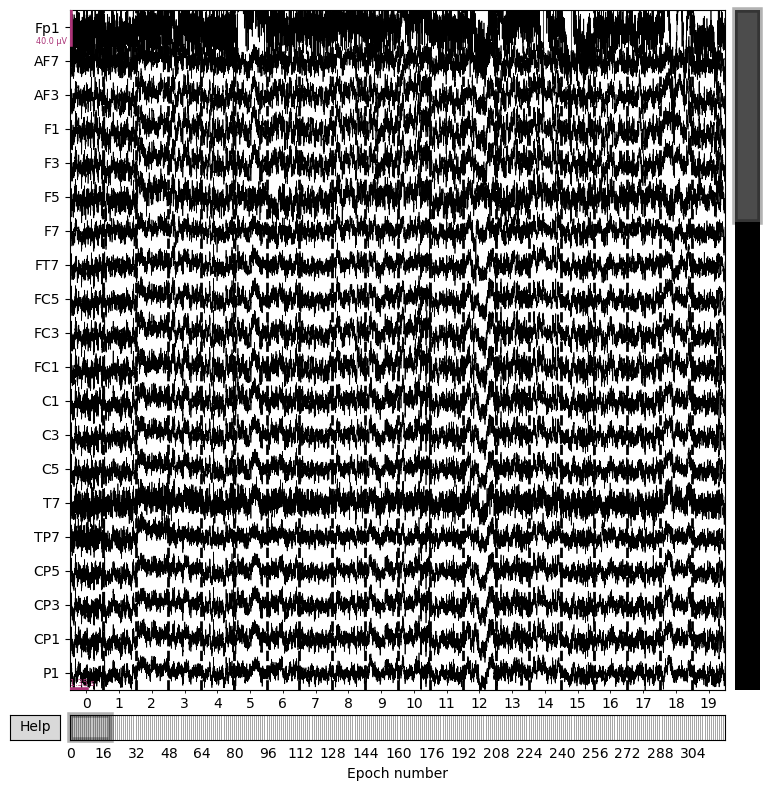

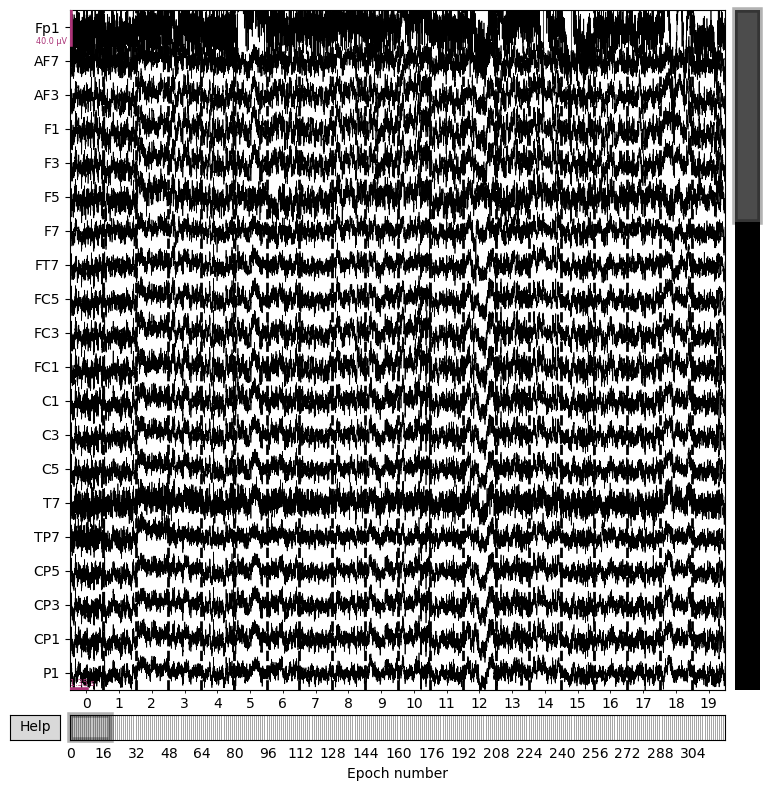

In [8]:
# Plot the epochs
sub01.plot()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Not setting metadata
320 matching events found
No baseline correction applied
0 projection items activated


C:\Users\jixia\miniconda3\envs\neuromophic\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


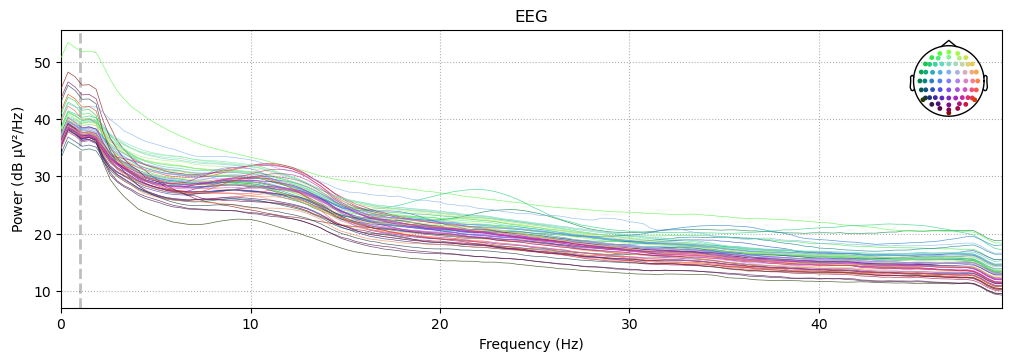

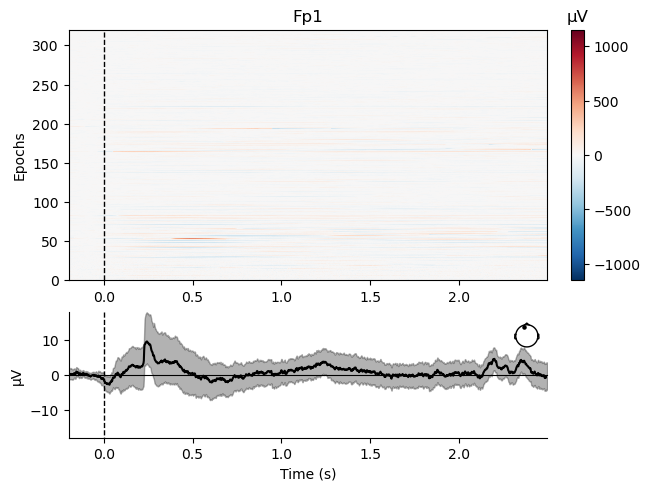

[<Figure size 640x480 with 4 Axes>]

In [9]:
sub01.plot_psd(fmax=50)  # Plot power spectral density up to 50 Hz
sub01.plot_image(picks='Fp1')  # Plot image of channel 'Fp1'

In [10]:
sub01.apply_baseline(baseline=(-0.2, 0))  # Apply baseline correction using the pre-stimulus interval

Applying baseline correction (mode: mean)


<EpochsFIF | 320 events (all good), -0.199 – 2.498 s (baseline -0.2 – 0 s), ~216.0 MB, data loaded, with metadata,
 'ten': 40
 'wife': 40
 'six': 40
 'father': 40
 'four': 40
 'three': 40
 'child': 40
 'daughter': 40>

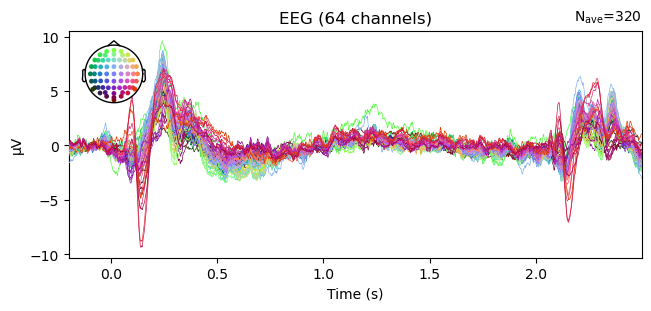

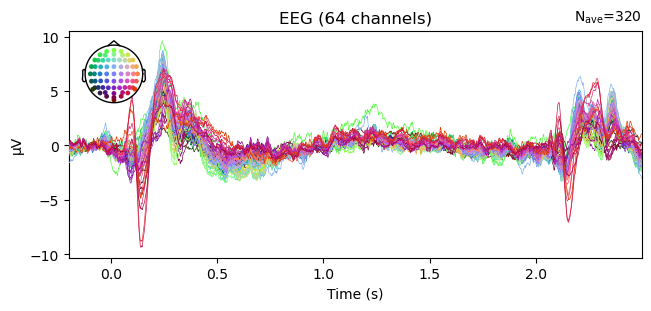

In [11]:
evoked = sub01.average()
evoked.plot()

# Downsampling and select channels

In [ ]:
class Preprocess:
    def __init__(self, filepath):
        pass

In [12]:
# downsample to 100 Hz
sub01_resampled = sub01.copy().resample(100, npad='auto')


In [14]:
sub01_resampled.get_data().shape

(320, 64, 270)

######################################################

In [15]:

#data = sub01.get_data()
data = sub01_resampled.get_data()
# Normalize each channel to have values between 0 and 1
data_min = np.min(data, axis=-1, keepdims=True)
data_max = np.max(data, axis=-1, keepdims=True)
normalized_data = (data - data_min) / (data_max - data_min)


In [16]:
normalized_data.shape

(320, 64, 270)

In [17]:
# Extract events
events = sub01_resampled.events

# Extract event IDs (labels)
labels = events[:, 2]

In [18]:
# Target event ID
target_event_id = 128  # Replace with your specific event ID

# Find the indices of events with the target event ID
matching_event_indices = np.where(events[:, 2] == target_event_id)[0]

# Extract the matching events
matching_events = events[matching_event_indices]

matching_events.shape

(40, 3)

In [19]:
# important channels
# https://www.researchgate.net/publication/370148916_Inner_Speech_Classification_Using_EEG_and_Deep_Learning/fulltext/6441ce87b8ba5f00242b8676/Inner-Speech-Classification-Using-EEG-and-Deep-Learning.pdf

# Select relevant channels
# important_channels = ['F3', 'F4', 'Fz', 'FCz', 'C3', 'C4', 'Cz', 'T3', 'T4', 'T7', 'T8', 'P3', 'P4', 'Pz']
important_channels = ['Fz',  'C3', 'C4', 'Cz', 'P7', 'P8', 'Pz', 'Oz']

# Assuming the epochs object contains the channel names
important_channels = ['Fz', 'C3', 'C4', 'Cz', 'P7', 'P8', 'Pz', 'Oz']
all_channel_names = sub01.ch_names

# Find the indices of the important channels
important_indices = [all_channel_names.index(ch) for ch in important_channels]

selected_data = normalized_data[:, important_indices, :]

print("Selected data shape:", selected_data.shape)


Selected data shape: (320, 8, 270)


In [282]:
events_ten = sub01['ten']
print(events_ten.get_data().shape)
ten = events_ten.get_data()[:, important_indices, :]
# Normalize each channel to have values between 0 and 1
data_min = np.min(ten, axis=-1, keepdims=True)
data_max = np.max(ten, axis=-1, keepdims=True)
ten = (ten - data_min) / (data_max - data_min)
print(ten.shape)

(40, 64, 1382)
(40, 8, 1382)


# Spike train

Encode EEG signal into Spike train: https://akshaybabloo.github.io/Spikes/encoder.html

In [14]:
def ben_spiker_algorithm(signal, threshold=0.5):
    """
    Generate a spike train using Ben's Spiker Algorithm.
    
    signal: 1D array of normalized signal values (0 to 1)
    threshold: threshold value for generating spikes
    
    Returns a binary array representing the spike train.
    """
    spike_train = np.zeros_like(signal)
    above_threshold = False

    for i in range(1, len(signal)):
        if signal[i] > threshold and not above_threshold:
            spike_train[i] = 1
            above_threshold = True
        elif signal[i] < threshold:
            above_threshold = False

    return spike_train

In [264]:
import matplotlib.pyplot as plt

def plot_raster(spike_train):
    """
    Plot a raster plot of the spike train.
    
    spike_train: 1D array of binary values (0 or 1) representing the spike train
    """
    # Find the times of spikes
    spike_times = np.where(spike_train == 1)[0]

    # Create the raster plot
    plt.eventplot(spike_times, orientation='horizontal', colors='black')
    plt.xlabel('Time (ms)')
    plt.ylabel('Trial')
    plt.title('Raster Plot of Spike Train')
    plt.show()

def raster_plot(spike_data):
    num_channels, time_points = spike_data.shape
    plt.figure(figsize=(12, 6))

    for i in range(num_channels):
        spike_times = np.where(spike_data[i])[0]
        plt.scatter(spike_times, np.ones_like(spike_times) * i, s=1, color='black')

    plt.xlabel('Time')
    plt.ylabel('Channel')
    plt.title('Raster Plot of Spiking Activity')
    plt.yticks(range(num_channels))
    plt.show()

def raster_plot(spike_data):
    num_events = len(spike_data)
    plt.figure(figsize=(12, 6))

    for event_idx, spike_event_data in enumerate(spike_data):
        num_channels, time_points = spike_event_data.shape
        y_offset = event_idx * num_channels  # Offset for each event

        for i in range(num_channels):
            spike_times = np.where(spike_event_data[i])[0]
            plt.scatter(spike_times, np.ones_like(spike_times) * (i + y_offset), s=1, color='black')

    plt.xlabel('Time')
    plt.ylabel('Channel/Event')
    plt.title('Raster Plot of Spiking Activity')
    plt.show()



In [284]:
spike_train = np.array([[ben_spiker_algorithm(ten[e, c], threshold) for c in range(ten.shape[1])] for e in range(ten.shape[0])])

In [287]:
spike_train.shape

(40, 8, 1382)

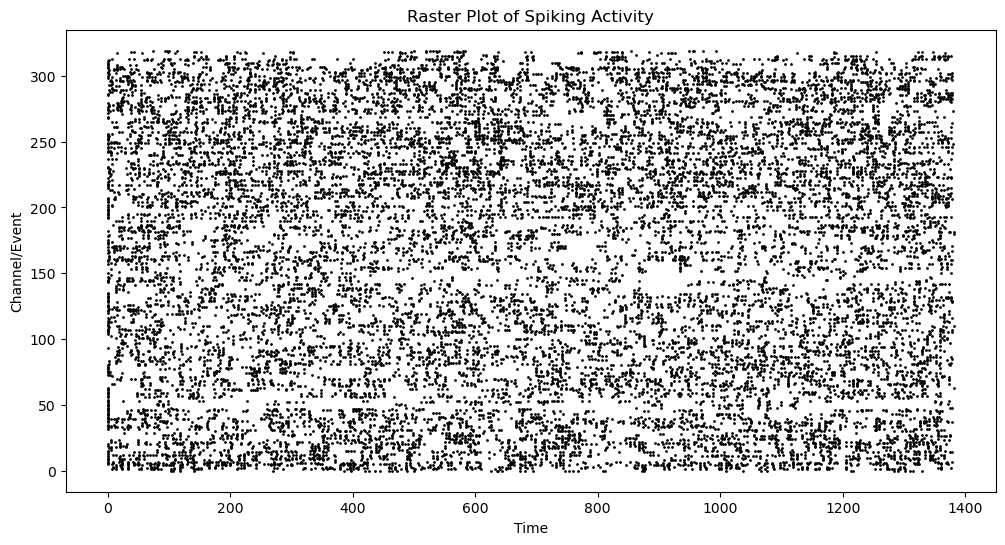

In [286]:
raster_plot(spike_train)

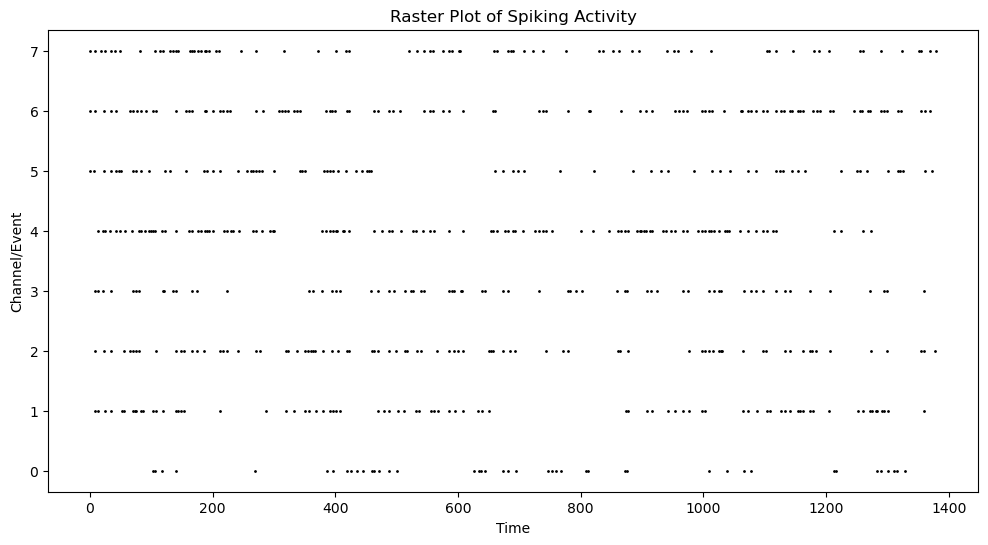

In [291]:
raster_plot([spike_train[0]])

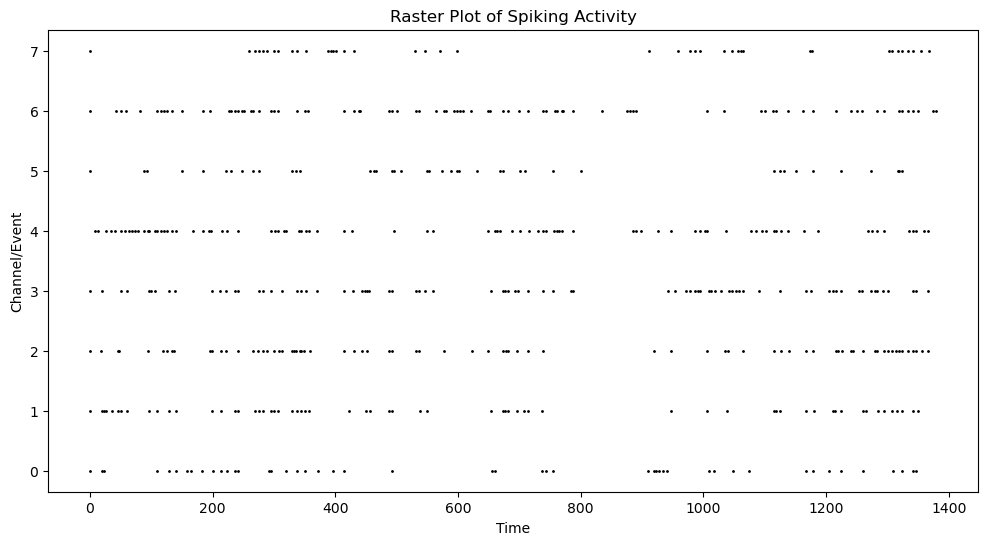

In [292]:
raster_plot([spike_train[1]])

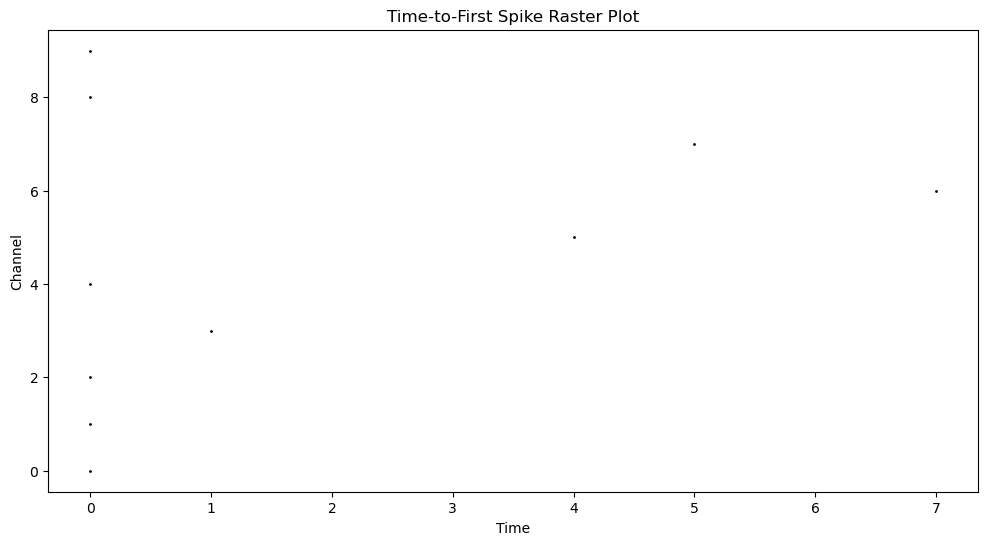

In [295]:
import numpy as np
import matplotlib.pyplot as plt

def time_to_first_spike(eeg_data, threshold):
    spike_train = np.zeros_like(eeg_data)
    for i in range(eeg_data.shape[0]):
        for j in range(eeg_data.shape[1]):
            if eeg_data[i, j] > threshold:
                spike_train[i, j] = 1
                break  # Stop after the first spike is detected
    return spike_train

# Example EEG data (replace with your actual data)
eeg_data = np.random.rand(10, 1000)  # 10 channels, 1000 time points
threshold = 0.5  # Example threshold

# Generate the spike train
spike_train = time_to_first_spike(eeg_data, threshold)

# Plot the spike train
plt.figure(figsize=(12, 6))
for i in range(spike_train.shape[0]):
    spike_times = np.where(spike_train[i])[0]
    plt.scatter(spike_times, np.ones_like(spike_times) * i, s=1, color='black')

plt.xlabel('Time')
plt.ylabel('Channel')
plt.title('Time-to-First Spike Raster Plot')
plt.show()


# Create train, val and test dataset

In [9]:
def one_hot_encode(labels, num_labels=8):
    """
    One-hot encode labels, ensuring similar labels have more cosine similarity.
    
    labels: list of labels to encode
    group_mapping: mapping from label to index within the groups
    num_labels: total number of unique labels
    
    Returns: tensor of one-hot encoded labels
    """
    one_hot_labels = torch.zeros(len(labels), num_labels, dtype=dtype)
    
    for i, label in enumerate(labels):
        one_hot_labels[i, int(str(label)[-1])-1] = 1.0       
    return one_hot_labels

In [10]:
# Define the folder path
train_path = './data/train'
train_sub = []
# Loop through every file in the folder
for filename in os.listdir(train_path):
    file_path = os.path.join(train_path, filename)
    sub_name = 'sub'+ filename.split('_')[0][7:]
    sub_name = mne.read_epochs(file_path)
    train_sub.append(sub_name)

Reading C:\Users\jixia\Downloads\Boying\NC\project\data\train\subject01_session01_eeg-epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    2498.05 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
320 matching events found
No baseline correction applied
0 projection items activated
Reading C:\Users\jixia\Downloads\Boying\NC\project\data\train\subject02_session01_theta_eeg-epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    2498.05 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
320 matching events found
No baseline correction applied
0 projection items activated
Reading C:\Users\jixia\Downloads\Boying\NC\project\data\train\subject03_session01_delta_eeg-epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    2498.05 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
320 matching events found
No baseline correction applied
0 projection it

In [15]:
train_labels = []
train_trains = []
for sub in train_sub:
    sub.apply_baseline(baseline=(-0.2, 0)) 
    sub_resampled = sub.copy().resample(200, npad='auto')
    data = sub_resampled.get_data()
    # Normalize each channel to have values between 0 and 1
    data_min = np.min(data, axis=-1, keepdims=True)
    data_max = np.max(data, axis=-1, keepdims=True)
    normalized_data = (data - data_min) / (data_max - data_min)
    # Find the indices of the important channels
    # all_channel_names = sub.ch_names
    # important_indices = [all_channel_names.index(ch) for ch in important_channels]

    # selected_data = normalized_data[:, important_indices, :]
    selected_data = normalized_data
    # Generate spike trains for each epoch and channel
    train_trains.append(np.array([[ben_spiker_algorithm(selected_data[e, c], threshold)
                          for c in range(selected_data.shape[1])]
                         for e in range(selected_data.shape[0])]))
    # Extract events
    events = sub_resampled.events

    # Extract event IDs (labels)
    train_labels.append(events[:, 2])

# Convert to PyTorch tensors
train_trains = np.concatenate(train_trains, axis=0)
train_labels = np.concatenate(train_labels, axis=0)


Applying baseline correction (mode: mean)


NameError: name 'threshold' is not defined

In [212]:
train_labels = one_hot_encode(train_labels)

In [213]:
train_spike = torch.tensor(train_trains, dtype=torch.float32)
train_spike = train_spike.permute(0, 2, 1)

In [214]:
train_spike.shape

torch.Size([960, 540, 8])

In [215]:
# Create a dataset and DataLoader
trainset = TensorDataset(train_spike, train_labels)
dataset_size = len(trainset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True, drop_last=False)

# Build a simple SNN using snntorch

In [216]:
# Network Architecture
num_inputs = 8
num_hidden = 1000
num_outputs = 8

# Temporal Dynamics
num_steps = example_spike.shape[1]
beta = 0.95

batch_size = 32
dtype = torch.float

In [217]:
example_spike, example_label = next(iter(train_loader))
example_spike.shape, example_label.shape

(torch.Size([32, 540, 8]), torch.Size([32, 8]))

In [218]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x[:,step,:])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)


In [219]:
net = Net()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-3, betas=(0.9, 0.999))

In [221]:
spk_rec, mem_rec = net(example_spike)
print(mem_rec.size())

torch.Size([270, 32, 8])


In [222]:
num_epochs = 10
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        
        # forward pass
        net.train()
        spk_rec, mem_rec = net(data)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(val_loader))
            # Test set forward pass
            test_spk, test_mem = net(test_data)

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            counter += 1
            iter_counter +=1

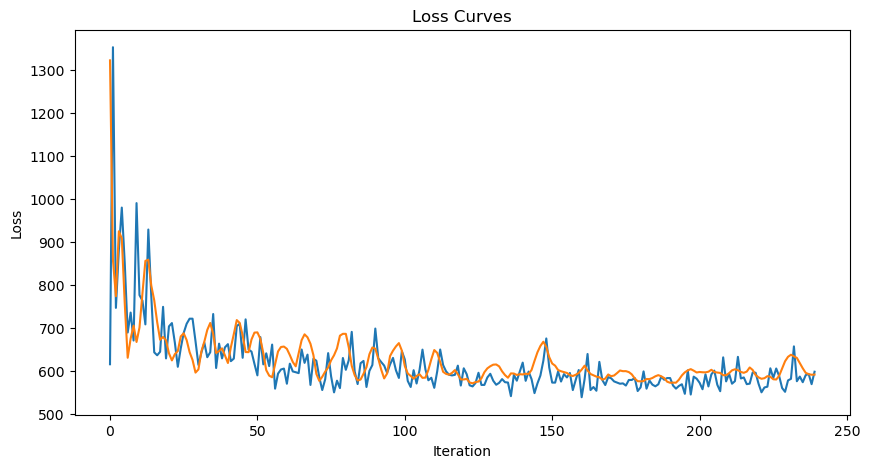

In [223]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [189]:
        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_counter +=1


NameError: name 'device' is not defined

# Test accuracy

In [224]:
sub05 = mne.read_epochs('./data/subject05_session01_theta_eeg-epo.fif')
sub05.apply_baseline(baseline=(-0.2, 0)) 
sub05_resampled = sub05.copy().resample(200, npad='auto')
data = sub05_resampled.get_data()
# Normalize each channel to have values between 0 and 1
data_min = np.min(data, axis=-1, keepdims=True)
data_max = np.max(data, axis=-1, keepdims=True)
normalized_data = (data - data_min) / (data_max - data_min)
# Find the indices of the important channels
all_channel_names = sub05.ch_names
important_indices = [all_channel_names.index(ch) for ch in important_channels]

selected_data = normalized_data[:, important_indices, :]

print("Selected data shape:", selected_data.shape)
# Generate spike trains for each epoch and channel
spike_trains = np.array([[ben_spiker_algorithm(selected_data[e, c], threshold)
                          for c in range(selected_data.shape[1])]
                         for e in range(selected_data.shape[0])])
# Extract events
events = sub05_resampled.events

# Extract event IDs (labels)
labels = events[:, 2]

# Convert to PyTorch tensors
spike_tensor = torch.tensor(spike_trains, dtype=torch.float32)
spike_tensor = spike_tensor.permute(0, 2, 1)
labels_tensor = one_hot_encode(labels)

# Create a dataset and DataLoader
testset = TensorDataset(spike_tensor, labels_tensor)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True, drop_last=False)

Reading C:\Users\jixia\Downloads\Boying\NC\project\data\subject05_session01_theta_eeg-epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    2498.05 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
321 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Selected data shape: (321, 8, 540)


In [225]:
example_spike, example_label = next(iter(test_loader))
example_spike.shape, example_label.shape

(torch.Size([32, 540, 8]), torch.Size([32, 8]))

In [226]:
total = 0
correct = 0

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:

    # forward pass
    test_spk, _ = net(data)

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets.argmax(dim=1)).sum().item()

In [227]:
targets.argmax(dim=1)

tensor([0])

In [228]:
test_spk.sum(dim=0).argmax(dim=1)

tensor([4])

In [229]:
correct

40

In [196]:
len(test_loader)

11

# ---------------------------CNN + SNN--------------------------

In [1]:
# Define a simple CNN for feature extraction
class FeatureExtractorCNN(nn.Module):
    def __init__(self):
        super(FeatureExtractorCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 500, 128)  # Adjust dimensions based on input size

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 32 * 500)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        return x

# Example EEG data (10 samples, 64 channels, 1000 time points)
eeg_data = torch.randn(10, 64, 1000)

# Instantiate and apply the feature extractor
cnn = FeatureExtractorCNN()
features = cnn(eeg_data)


In [2]:
from snntorch.spikegen import latency

# Encode the features into spike train
spike_train = latency(features, num_steps=100, threshold=0.5)

print(spike_train.shape)  # Check the shape of the spike train


torch.Size([100, 10, 128])


In [6]:
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import spikegen

# Define an SNN model with LIF neurons
class SpikingNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SpikingNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.lif1 = snn.Leaky(beta=0.95)  # LIF neuron
        self.fc2 = nn.Linear(128, output_dim)
        self.lif2 = snn.Leaky(beta=0.95)  # LIF neuron

    def forward(self, x):
        mem1, spk1 = self.lif1.init_leaky()
        mem2, spk2 = self.lif2.init_leaky()

        cur1 = self.fc1(x)
        spk1, mem1 = self.lif1(cur1, mem1)
        cur2 = self.fc2(spk1.float())
        spk2, mem2 = self.lif2(cur2, mem2)
        
        return spk2



# Define the SNN
snn = SpikingNN(input_dim=128, output_dim=10)  # Example dimensions

# Forward pass with the spike train
output = snn(spike_train.float())

print(output.shape)


ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
# Example EEG data (10 samples, 64 channels, 1000 time points)
eeg_data = torch.randn(10, 64, 1000)
labels = torch.randint(0, 2, (10,))

# Number of epochs
num_epochs = 10

for epoch in range(num_epochs):
    # Zero the parameter gradients
    optimizer_cnn.zero_grad()
    optimizer_snn.zero_grad()

    # Forward pass through CNN
    features = cnn(eeg_data)

    # Encode features into spike trains
    spike_train = spikegen.latency(features, num_steps=100, threshold=0.5)

    # Forward pass through SNN
    outputs = snn(spike_train.float())

    # Calculate loss
    loss = criterion(outputs, labels)

    # Backward pass for CNN
    loss.backward(retain_graph=True)  # Retain computational graph for SNN

    # Surrogate gradient step for SNN
    optimizer_snn.step()
    optimizer_cnn.step()  # Update CNN parameters

    # Print loss
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

# Evaluate the model (example)
outputs = snn(spike_train.float())
test_loss = criterion(outputs, labels).item()
test_accuracy = (outputs.argmax(dim=1) == labels).float().mean().item()
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')
